 [-----------------100%-----------------] 1000 of 1000 complete in 10.9 sec

:0: FutureWarning: IPython widgets are experimental and may change in the future.


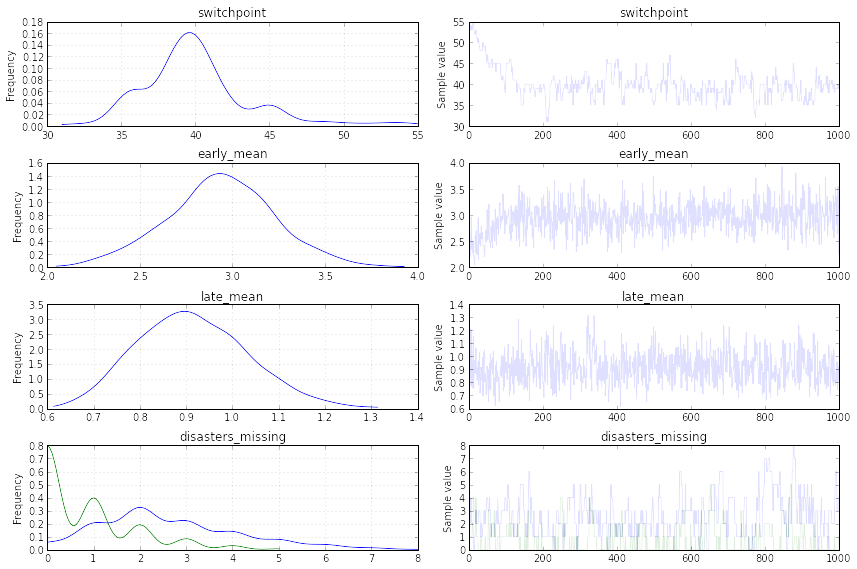

In [1]:
%matplotlib inline
"""
A model for coal mining disasters data with a changepoint

switchpoint ~ U(0, 110)
early_mean ~ Exp(1.)
late_mean ~ Exp(1.)
disasters[t] ~ Po(early_mean if t <= switchpoint, late_mean otherwise)

"""

from pymc3 import *

import theano.tensor as t
from numpy import arange, array, ones, concatenate
from numpy.random import randint
from numpy.ma import masked_values

__all__ = ['disasters_data', 'switchpoint', 'early_mean', 'late_mean', 'rate',
             'disasters']

# Time series of recorded coal mining disasters in the UK from 1851 to 1962
disasters_data = masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, -1, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, -1, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-1)
years = len(disasters_data)

with Model() as model:

    # Prior for distribution of switchpoint location
    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=years)
    # Priors for pre- and post-switch mean number of disasters
    early_mean = Exponential('early_mean', lam=1.)
    late_mean = Exponential('late_mean', lam=1.)

    # Allocate appropriate Poisson rates to years before and after current
    # switchpoint location
    idx = arange(years)
    rate = switch(switchpoint >= idx, early_mean, late_mean)

    # Data likelihood
    disasters = Poisson('disasters', rate, observed=disasters_data)


def run(n=1000):
    if n == "short":
        n = 50
    with model:

        # Initial values for stochastic nodes
        start = {'early_mean': 2., 'late_mean': 3.}

        # Use slice sampler for means
        step1 = Slice([early_mean, late_mean])
        # Use Metropolis for switchpoint, since it accomodates discrete variables
        step2 = Metropolis([switchpoint] +model.missing_values)

        tr = sample(n, tune=500, start=start, step=[step1, step2])
        traceplot(tr)

if __name__ == '__main__':
    run()
